# Introduction
In this notebook we are going to "engineer" some descriptive features which we will use predict to the probability whether a company would default on a loan in the future or not.

Let's import some packages we'll use for manipulating and visualising the data.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from plotnine import *
pd.set_option('mode.chained_assignment',None)

# Data Collection
We already created our study sample in the previous notebook. There is a copy of this sample which is publicly available in the GitHub [repo](https://github.com/data-analytics-in-business/gabor-firm-exit-case-study). Therefore we just need to use the `read_csv` method to download and import the data using its URL path.

In [2]:
url = "https://github.com/data-analytics-in-business/gabor-firm-exit-case-study/raw/main/data/sample_2012.csv"
sample = pd.read_csv(url)
sample.head()

,comp_id,begin,end,COGS,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,...,origin,nace_main,ind2,ind,urban_m,region_m,founded_date,exit_date,labor_avg,default
0,1001541.0,2012-01-01,2012-12-31,NaN,481.481476,9629.629883,1303.703735,0.0,0.000000,0.000000,...,Domestic,5610.0,56.0,3.0,3,Central,2008-02-24,NaN,NaN,0
1,1002029.0,2012-01-01,2012-12-31,NaN,14929.629883,203885.187500,120444.453125,0.0,0.000000,0.000000,...,Domestic,2711.0,27.0,2.0,3,East,2006-07-03,NaN,0.458333,0
2,1003200.0,2012-01-01,2012-12-31,NaN,25.925926,22.222221,10996.295898,0.0,0.000000,0.000000,...,Domestic,5630.0,56.0,3.0,1,Central,2003-10-21,2014-08-09,NaN,1
3,1011889.0,2012-01-01,2012-12-31,NaN,36625.925781,160166.671875,18911.111328,0.0,0.000000,0.000000,...,Domestic,5510.0,55.0,3.0,2,West,1992-11-09,NaN,1.621212,0
4,1014183.0,2012-01-01,2012-12-31,NaN,12551.851562,199903.703125,8274.074219,0.0,7.407407,7.407407,...,Domestic,5510.0,55.0,3.0,2,Central,2001-12-21,NaN,0.715278,0


# Feature Engineering
We are not going to be using all the columns in the sample to create features. Let's assume we discussed with the client organisation (the bank) and they suggested developing a *baseline* model which uses data relating to sales, profit & loss, and the industry category of the organisation.

We will now inspect each of these *domain concepts* and consider how we might use them to engineer features.

**Note**: For the benefit of what is to come, we will ensure our target feature `default` is set to be a *string* type object.

In [3]:
sample['default'] = sample['default'].astype(str)

## Sales
Let's first investigate the sales data for the companies in our sample. We will use the `ggplot` function from the `plotnine` [package](https://plotnine.readthedocs.io/en/stable/index.html). Don't worry too much about the details of the plotting package, it's just a tool we use here to quickly create some visualisations for the purpose of investigation.

Run the code below to create a plot of the `sales` data from the `sample` to create a histogram plot of the sales data.

**Note**: We also use our `default` target feature to split and plot the sales data separately for companies we believe would and would not default in the future.

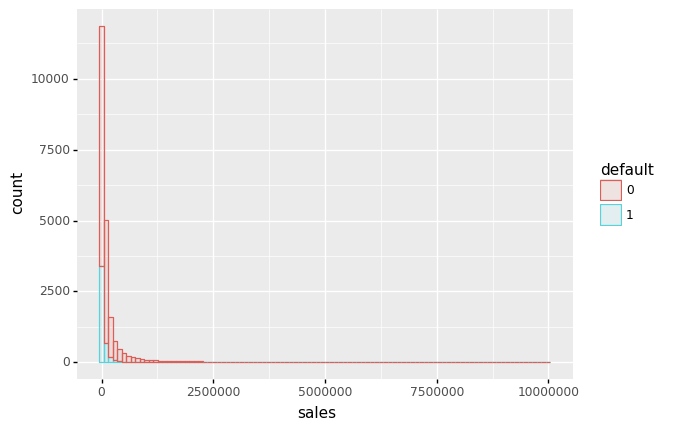

<ggplot: (276670321)>

In [4]:
(ggplot(sample, aes(x='sales', color='default', fill='default'))
     + geom_histogram(bins=100,alpha=0.1)
)

We see from the plot that distrobution of the sales data has a very [long tail](https://en.wikipedia.org/wiki/Long_tail). When this is the case, we wil often [*transform*](https://en.wikipedia.org/wiki/Data_transformation_(statistics)) the data before we pass it to a machine learning model. One way to do this (for data > 0) is to perform a [logarithm](https://en.wikipedia.org/wiki/Logarithm) (log) transformation.

Let's use the `numpy` package to log-transform our sales data and then visualise it again.

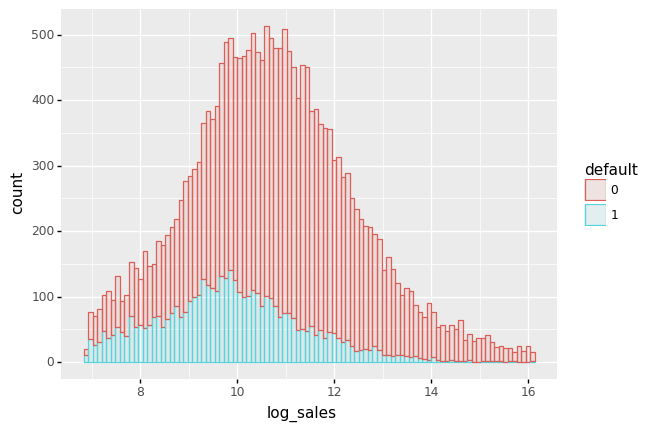

<ggplot: (313127309)>

In [5]:
sample['log_sales'] = np.log(sample['sales'])
(ggplot(sample, aes(x='log_sales', color='default', fill='default'))
     + geom_histogram(bins=100,alpha=0.1)
)

The data looks much more [*normal*](https://en.wikipedia.org/wiki/Normal_distribution) now, and we can even start to see a difference in the distribution of 2012 sales for companies who we believe will default in 2014...

## Profit and Loss
Let's now visualise the distributions of profit (P&L) and loss data in the same way.

/Users/matt/Bristol/Github/data-analytics-in-business/gabor-firm-exit-case-study/.env/lib/python3.7/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_bin : Removed 10 rows containing non-finite values.


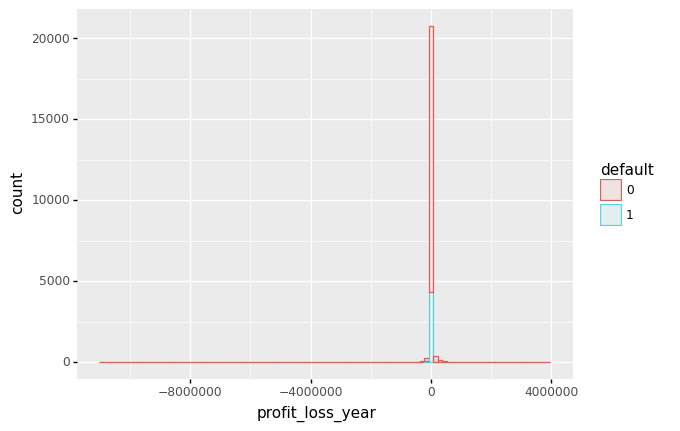

<ggplot: (313395565)>

In [6]:
(ggplot(sample, aes(x='profit_loss_year', color='default', fill='default'))
     + geom_histogram(bins=100,alpha=0.1)
)

The distribution of P&L values also have very long tail(s), but this time they are negative as well as positive. We are going to need to use a slightly more advanced transformation.

**Note**: There is a warning above which we can remove by *imputing* the NA values from the `profit_loss_year` column.

Run the code below to transform the P&L values, impute the NA values, and visualise the transformed data.

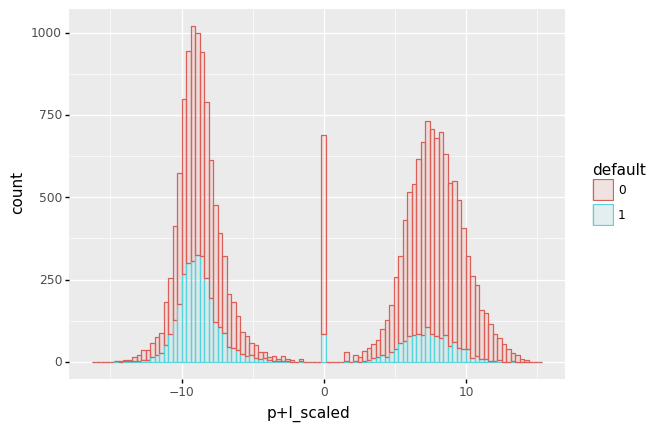

<ggplot: (313564469)>

In [7]:
sample['p+l_scaled'] = np.sign(sample['profit_loss_year'])*(np.log(np.abs(sample['profit_loss_year'])+1))
sample['p+l_scaled'] = np.where(sample['p+l_scaled'].isna(), 0, sample['p+l_scaled'])

(ggplot(sample, aes(x='p+l_scaled', color='default', fill='default'))
     + geom_histogram(bins=100,alpha=0.1)
)

The transformed data is not "normal" because it is [*bimodal*](https://en.wikipedia.org/wiki/Multimodal_distribution), but it is again much easier to see a difference companies who we believe will and will not default in 2014.

## Industry type
Finally, we investigate the industry types of the companies in our sample. We use the `ind` column and create an additional category `0` for companies that have NA in the `ind` column. We also ensure the final `ind_cat` feature is a *string* so that it is not confused to be numeric.

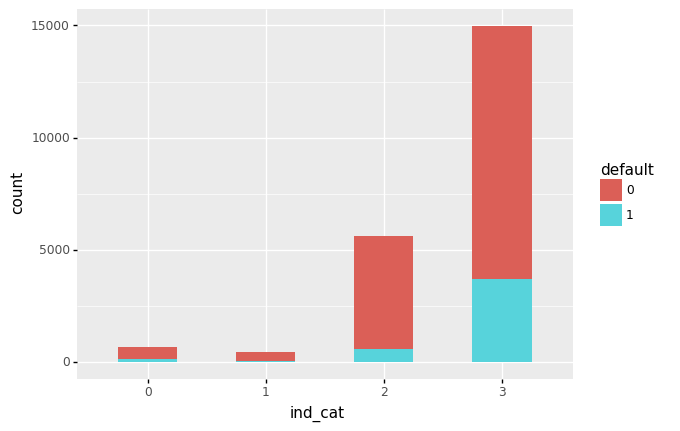

<ggplot: (314252433)>

In [8]:
sample['ind_cat'] = sample['ind']
sample['ind_cat'] = np.where(sample['ind_cat'].isna(), 0, sample['ind_cat'])
sample['ind_cat'] = sample['ind_cat'].astype(int).astype(str)
(ggplot(sample, aes(x='ind_cat',fill='default'))
 + geom_histogram(binwidth=0.5)
)

# Analytics Base Table
Now we have engineered descriptive features based suggested domain concepts, we can use them (along with our target feature) to create our final Analytics Base Table (ABT) which we will use for machine learning.

In [9]:
sample_ABT = sample[['log_sales','p+l_scaled','ind_cat','default']]
sample_ABT.to_csv('../data/sample_2012_ABT.csv', index=False)
sample_ABT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21723 entries, 0 to 21722
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   log_sales   21723 non-null  float64
 1   p+l_scaled  21723 non-null  float64
 2   ind_cat     21723 non-null  object 
 3   default     21723 non-null  object 
dtypes: float64(2), object(2)
memory usage: 679.0+ KB


# Exercise
In the code block below:
1. Transform the `curr_assets` column through a $log(x+1)$ function to create a new column named `log_assets`
2. Find the NA values in `log_assets` and impute them using the value `sample['log_assets'].mean()`
3. Visualise the distributions of the `log_assets` data for companies who we believe would and would not deafult

Based on the visualisation, do companies who would or would not default have more assests of average?

/Users/matt/Bristol/Github/data-analytics-in-business/gabor-firm-exit-case-study/.env/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log


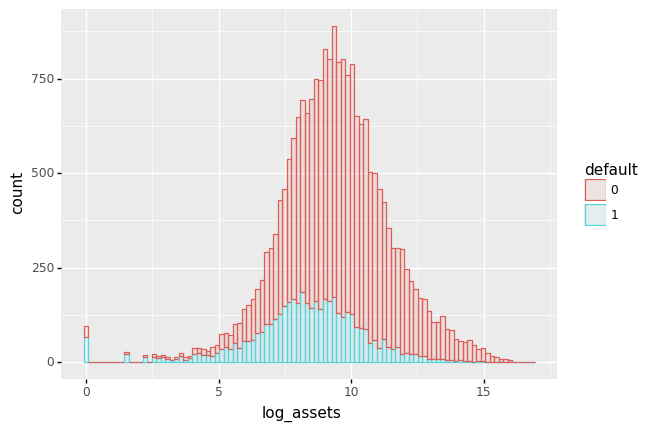

<ggplot: (313057877)>

In [10]:
# (SOLUTION)
sample['log_assets'] = np.log(sample['curr_assets']+1)
sample['log_assets'] = np.where(sample['log_assets'].isna(), sample['log_assets'].mean(), sample['log_assets'])
(ggplot(sample, aes(x='log_assets', color='default', fill='default'))
     + geom_histogram(bins=100,alpha=0.1)
)